In [25]:
import os, shutil, pathlib
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Create a smaller subset of dogs-vs-cats-db INTO training, validation, and test directories

In [10]:
if not os.path.exists('./cats_vs_dogs_small'):

    original_dir = pathlib.Path('./dogs-vs-cats-db/train') # path to the directory where original dataset was uncompressed
    new_base_dir = pathlib.Path('./cats_vs_dogs_small') # directory for our smaller dataset

    def make_subset(subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = new_base_dir / subset_name / category
            os.makedirs(dir)
            fnames = [f"{category}.{i}.jpg"
                    for i in range(start_index, end_index)]
            for fname in fnames:
                shutil.copyfile(src = original_dir / fname, dst = dir / fname)

    make_subset("train", start_index=0, end_index=1000)
    make_subset("validation", start_index=1000, end_index=1500)
    make_subset("test", start_index=1500, end_index=2500)

DATA AUGMENTATION NEEDED

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Setting up the architecture of the model

In [12]:
# model expects rgb images of size 180 x 180
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255) (x)#(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=2) (x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu") (x)
x = layers.Flatten() (x)
# augmentation
x = layers.Dropout(0.5) (x)

outputs = layers.Dense(1, activation="sigmoid") (x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [15]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Use `image_dataset_from_directory(dir)` from Keras to read img into model

* list the subdirectories of `dir` and assumes each one contains images from one of the classes
* then index the image files in each subdirectory
* this creates and returns a `tf.data.Dataset` object, which is configured to...
> 1. read these files,
> 2. shuffle them,
> 3. decode them to tensors,
> 4. resize to shared size,
> 5. pack them into batches.

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [17]:
# displaying the shapes of the data and labels yielded by the 'Dataset' obj

for data_batch, labels_batch, in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [22]:
# MODEL FIT into 'history'
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5585INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 332ms/step - loss: 0.6962 - accuracy: 0.5585 - val_loss: 0.6877 - val_accuracy: 0.5830
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5780INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 325ms/step - loss: 0.6847 - accuracy: 0.5780 - val_loss: 0.6586 - val_accuracy: 0.6310
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.6270INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 333ms/step - loss: 0.6463 - accuracy: 0.6270 - val_loss: 0.6248 - val_accuracy: 0.6290
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.6505INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 331ms/step - loss: 0.6328 - accuracy: 0.6505 - val_loss: 0.6073 - val_accuracy: 0.6610
Epoch 5/100
63/63 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6840INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 329ms/step - loss: 0.5936 - accuracy: 0.6840 - val_loss: 0.5969 - val_accuracy: 0.6530
Epoch 6/100
63/63 [==============================] - 19s 307ms/step - loss: 0.5933 - accuracy: 0.6935 - val_loss: 0.6145 - val_accuracy: 0.6420
Epoch 7/100
63/63 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.6880INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 316ms/step - loss: 0.5823 - accuracy: 0.6880 - val_loss: 0.5721 - val_accuracy: 0.6820
Epoch 8/100
63/63 [==============================] - 20s 311ms/step - loss: 0.5818 - accuracy: 0.6950 - val_loss: 0.5952 - val_accuracy: 0.6760
Epoch 9/100
63/63 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7085INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 326ms/step - loss: 0.5813 - accuracy: 0.7085 - val_loss: 0.5486 - val_accuracy: 0.6980
Epoch 10/100
63/63 [==============================] - 20s 319ms/step - loss: 0.5603 - accuracy: 0.7200 - val_loss: 0.5895 - val_accuracy: 0.6910
Epoch 11/100
63/63 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.7135INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 330ms/step - loss: 0.5596 - accuracy: 0.7135 - val_loss: 0.5237 - val_accuracy: 0.7440
Epoch 12/100
63/63 [==============================] - 20s 318ms/step - loss: 0.5374 - accuracy: 0.7285 - val_loss: 0.5907 - val_accuracy: 0.7120
Epoch 13/100
63/63 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7310INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 329ms/step - loss: 0.5336 - accuracy: 0.7310 - val_loss: 0.5005 - val_accuracy: 0.7480
Epoch 14/100
63/63 [==============================] - ETA: 0s - loss: 0.5320 - accuracy: 0.7305INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 322ms/step - loss: 0.5320 - accuracy: 0.7305 - val_loss: 0.4991 - val_accuracy: 0.7580
Epoch 15/100
63/63 [==============================] - 20s 318ms/step - loss: 0.5317 - accuracy: 0.7355 - val_loss: 0.5298 - val_accuracy: 0.7230
Epoch 16/100
63/63 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.7535INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 318ms/step - loss: 0.5069 - accuracy: 0.7535 - val_loss: 0.4960 - val_accuracy: 0.7430
Epoch 17/100
63/63 [==============================] - 20s 314ms/step - loss: 0.4965 - accuracy: 0.7515 - val_loss: 0.5232 - val_accuracy: 0.7540
Epoch 18/100
63/63 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7510INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 335ms/step - loss: 0.4903 - accuracy: 0.7510 - val_loss: 0.4505 - val_accuracy: 0.7820
Epoch 19/100
63/63 [==============================] - 20s 311ms/step - loss: 0.4787 - accuracy: 0.7720 - val_loss: 0.4862 - val_accuracy: 0.7670
Epoch 20/100
63/63 [==============================] - 20s 312ms/step - loss: 0.4735 - accuracy: 0.7730 - val_loss: 0.4974 - val_accuracy: 0.7350
Epoch 21/100
63/63 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.7870INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 332ms/step - loss: 0.4629 - accuracy: 0.7870 - val_loss: 0.4386 - val_accuracy: 0.7860
Epoch 22/100
63/63 [==============================] - 20s 314ms/step - loss: 0.4380 - accuracy: 0.7955 - val_loss: 0.5072 - val_accuracy: 0.7710
Epoch 23/100
63/63 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.7845INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 318ms/step - loss: 0.4437 - accuracy: 0.7845 - val_loss: 0.4323 - val_accuracy: 0.7790
Epoch 24/100
63/63 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.7935INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 315ms/step - loss: 0.4361 - accuracy: 0.7935 - val_loss: 0.4190 - val_accuracy: 0.8080
Epoch 25/100
63/63 [==============================] - 19s 308ms/step - loss: 0.4229 - accuracy: 0.8055 - val_loss: 0.4489 - val_accuracy: 0.7890
Epoch 26/100
63/63 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8100INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 323ms/step - loss: 0.4229 - accuracy: 0.8100 - val_loss: 0.4152 - val_accuracy: 0.8190
Epoch 27/100
63/63 [==============================] - 20s 314ms/step - loss: 0.4216 - accuracy: 0.8035 - val_loss: 0.4392 - val_accuracy: 0.8170
Epoch 28/100
63/63 [==============================] - 20s 321ms/step - loss: 0.3932 - accuracy: 0.8210 - val_loss: 0.4978 - val_accuracy: 0.7670
Epoch 29/100
63/63 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8260INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 331ms/step - loss: 0.3869 - accuracy: 0.8260 - val_loss: 0.3996 - val_accuracy: 0.8080
Epoch 30/100
63/63 [==============================] - 20s 310ms/step - loss: 0.4031 - accuracy: 0.8135 - val_loss: 0.5506 - val_accuracy: 0.7740
Epoch 31/100
63/63 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.8385INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 21s 332ms/step - loss: 0.3706 - accuracy: 0.8385 - val_loss: 0.3883 - val_accuracy: 0.8290
Epoch 32/100
63/63 [==============================] - 19s 307ms/step - loss: 0.3624 - accuracy: 0.8415 - val_loss: 0.4179 - val_accuracy: 0.8170
Epoch 33/100
63/63 [==============================] - 19s 309ms/step - loss: 0.3788 - accuracy: 0.8350 - val_loss: 0.4369 - val_accuracy: 0.8050
Epoch 34/100
63/63 [==============================] - 19s 307ms/step - loss: 0.3660 - accuracy: 0.8380 - val_loss: 1.9763 - val_accuracy: 0.6010
Epoch 35/100
63/63 [==============================] - 19s 305ms/step - loss: 0.3685 - accuracy: 0.8435 - val_loss: 0.4996 - val_accuracy: 0.7870
Epoch 36/100
63/63 [==============================] - 19s 306ms/step - loss: 0.3508 - accuracy: 0.8545 - val_loss: 0.5118 - val_accuracy: 0.7960
Epoch 37/100
63/63 [==============================] - 19s 307ms/step - loss: 0.3321 - accuracy: 0.8630 - val_loss: 0.4799 - val_accuracy: 0.824

INFO:tensorflow:Assets written to: convnet_from_scratch_with_augmentation.x/assets


63/63 [==============================] - 20s 323ms/step - loss: 0.3054 - accuracy: 0.8770 - val_loss: 0.3827 - val_accuracy: 0.8510
Epoch 45/100
63/63 [==============================] - 20s 310ms/step - loss: 0.2824 - accuracy: 0.8855 - val_loss: 0.8378 - val_accuracy: 0.7910
Epoch 46/100
63/63 [==============================] - 20s 311ms/step - loss: 0.2807 - accuracy: 0.8820 - val_loss: 0.3939 - val_accuracy: 0.8280
Epoch 47/100
63/63 [==============================] - 20s 318ms/step - loss: 0.2695 - accuracy: 0.8905 - val_loss: 0.4642 - val_accuracy: 0.8420
Epoch 48/100
63/63 [==============================] - 40s 637ms/step - loss: 0.2673 - accuracy: 0.8890 - val_loss: 0.4728 - val_accuracy: 0.8280
Epoch 49/100
63/63 [==============================] - 49s 771ms/step - loss: 0.2498 - accuracy: 0.8940 - val_loss: 0.5968 - val_accuracy: 0.8030
Epoch 50/100
63/63 [==============================] - 48s 766ms/step - loss: 0.2479 - accuracy: 0.8965 - val_loss: 0.4661 - val_accuracy: 0.831

Plot training accuracy vs validation accuracy

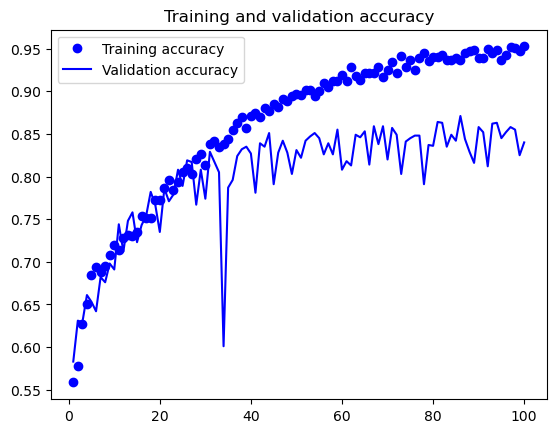

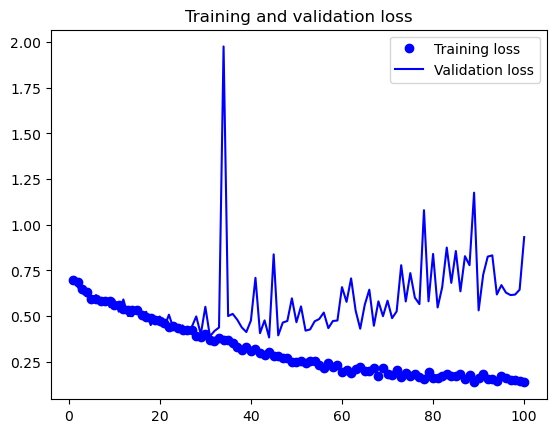

In [23]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Evaluate model on test set

In [24]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 47ms/step - loss: 0.4555 - accuracy: 0.8285
Test accuracy: 0.828


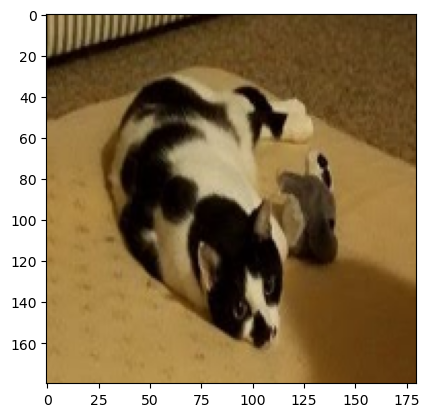

In [137]:
from PIL import Image

test_dog_path = './cats_vs_dogs_small/test/dog/dog.1507.jpg'
test_cat_path = './cats_vs_dogs_small/test/cat/cat.1500.jpg'
ivy = 'ivyBetter.png'
herbie = 'herbieSmall.png'

image = Image.open(ivy)

image = image.convert('RGB')
image = image.resize([180, 180])
plt.figure()
plt.imshow(image)

In [138]:
np_expanded_img = np.expand_dims(image, axis=0)
# img_scaled = np_expanded_img / 255.0

In [139]:
result = test_model.predict(np_expanded_img)
result

1/1 [==============================] - 0s 15ms/step


array([[0.8633477]], dtype=float32)

In [140]:
if result >= 0.5:
    print("THIS IS A VERY CUTE DOG :)")
else:
    print("THIS IS A VERY CUTE CAT :)")

THIS IS A VERY CUTE DOG :)
